## Final Project - Haejin Cho(hcho435)

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pytensor.tensor as pt

import os
import sys

# locally import pymetalog from https://github.com/jinjin-tonic/pymetalog, and locate it in the parent directory.
module_path = os.path.abspath(os.path.join('..', 'pymetalog'))

if module_path not in sys.path:
    sys.path.append(module_path)

import pymetalog as mt

### 1. Data Exploration

In [2]:
# Load the dataset
user1_df = pd.read_csv("./data/warp_data_user1.csv")
user2_df = pd.read_csv("./data/warp_data_user2.csv")
user3_df = pd.read_csv("./data/warp_data_user3_whale.csv", skiprows=1)

In [3]:
# we are only interested in type 11; user3 data only contains type 11
user1_df_11 = user1_df[user1_df["type"] == 11]
user2_df_11 = user2_df[user2_df["type"] == 11]

In [4]:
user1_df_11.head()

,uid,id,rarity,time,banner,type,manual
47,1731615000000035973,20007,3,2024-11-14T20:14:29.000Z,2049,11,False
48,1731615000000036073,20008,3,2024-11-14T20:14:29.000Z,2049,11,False
49,1731615000000036173,21046,4,2024-11-14T20:14:29.000Z,2049,11,False
50,1731615000000036273,1108,4,2024-11-14T20:14:29.000Z,2049,11,False
51,1731615000000036373,20019,3,2024-11-14T20:14:29.000Z,2049,11,False


In [5]:
user2_df_11.head()

,uid,id,rarity,time,banner,type,manual
92,1731550200000153622,20018,3,2024-11-14T02:15:35.000Z,2050,11,False
93,1731550200000153722,20009,3,2024-11-14T02:15:35.000Z,2050,11,False
94,1731550200000153822,20018,3,2024-11-14T02:15:35.000Z,2050,11,False
95,1731550200000153922,20019,3,2024-11-14T02:15:35.000Z,2050,11,False
96,1731550200000154022,20001,3,2024-11-14T02:15:35.000Z,2050,11,False


In [6]:
user3_df.head()

,uid,pull_number,rarity,type,did_win_featured,eidolon,pity_counter,pity_counter_featured
0,user3_pull1,1,3,11,NaN,NaN,1,1
1,user3_pull2,2,4,11,NaN,NaN,2,2
2,user3_pull3,3,3,11,NaN,NaN,3,3
3,user3_pull4,4,3,11,NaN,NaN,4,4
4,user3_pull5,5,3,11,NaN,NaN,5,5


In [7]:
# basic statistics
print(f"User1's total number of character pulls: {len(user1_df)}")
print(f"User2's total number of character pulls: {len(user2_df)}")
print(f"User3's total number of character pulls: {len(user3_df)}")

User1's total number of character pulls: 271
User2's total number of character pulls: 522
User3's total number of character pulls: 580


In [8]:
# the number of pulls results for each rarity
prop = pd.DataFrame(user1_df_11[["rarity"]].value_counts(normalize=True)).reset_index()
raw = user1_df_11[["rarity", "uid"]].groupby(["rarity"]).count().reset_index()

prop["raw_count"] = raw["uid"]
prop[["rarity", "raw_count", "proportion"]]

,rarity,raw_count,proportion
0,3,162,0.852632
1,4,25,0.131579
2,5,3,0.015789


In [9]:
# the number of pulls results for each rarity
prop = pd.DataFrame(user2_df_11[["rarity"]].value_counts(normalize=True)).reset_index()
raw = user2_df_11[["rarity", "uid"]].groupby(["rarity"]).count().reset_index()

prop["raw_count"] = raw["uid"]
prop[["rarity", "raw_count", "proportion"]]

,rarity,raw_count,proportion
0,3,315,0.855978
1,4,47,0.127717
2,5,6,0.016304


In [10]:
prop = pd.DataFrame(user3_df[["rarity"]].value_counts(normalize=True)).reset_index()
raw = user3_df[["rarity", "uid"]].groupby(["rarity"]).count().reset_index()

prop["raw_count"] = raw["uid"]
prop[["rarity", "raw_count", "proportion"]]

,rarity,raw_count,proportion
0,3,488,0.841379
1,4,82,0.141379
2,5,10,0.017241


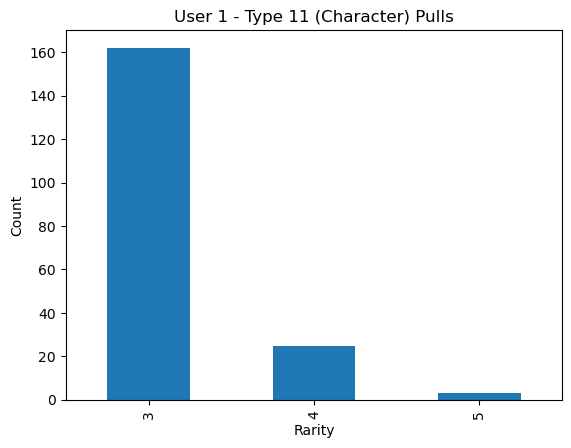

In [11]:
# distribution of the observed data
user1_df_11["rarity"].value_counts().plot(
    kind="bar",
    title="User 1 - Type 11 (Character) Pulls",
    xlabel="Rarity",
    ylabel="Count",
)
plt.show()

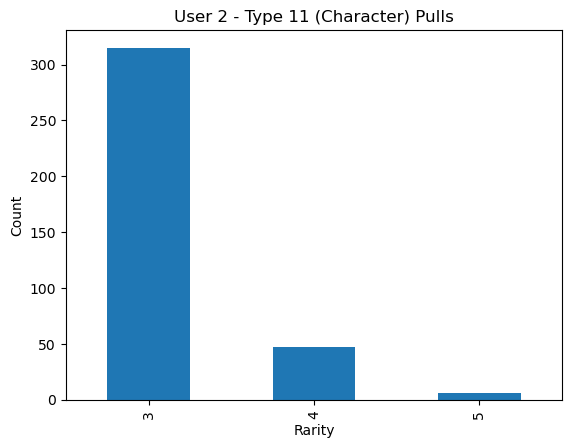

In [12]:
user2_df_11["rarity"].value_counts().plot(
    kind="bar",
    title="User 2 - Type 11 (Character) Pulls",
    xlabel="Rarity",
    ylabel="Count",
)
plt.show()

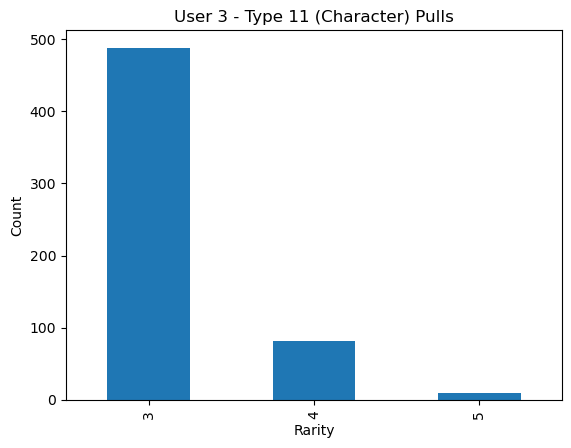

In [13]:
user3_df["rarity"].value_counts().plot(
    kind="bar",
    title="User 3 - Type 11 (Character) Pulls",
    xlabel="Rarity",
    ylabel="Count",
)
plt.show()

Pity count visualization for user3's 5 star pulls

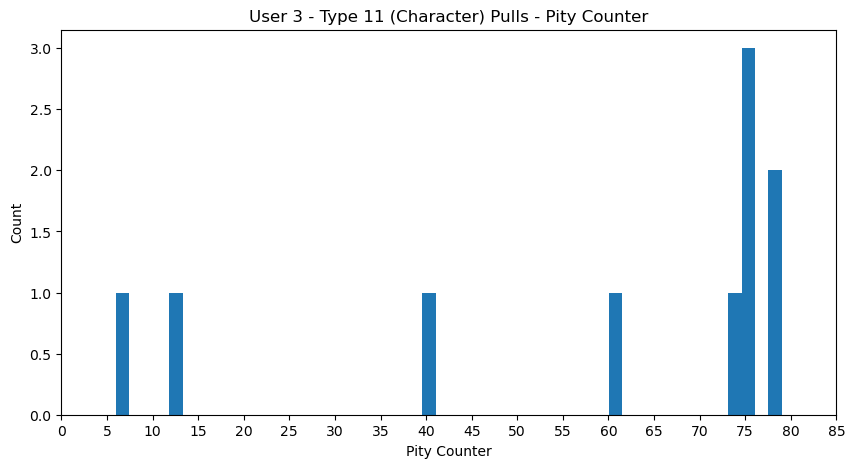

In [14]:
# pity count for rarity 5
user3_df[user3_df.rarity == 5].pity_counter.plot(
    kind="hist",
    title="User 3 - Type 11 (Character) Pulls - Pity Counter",
    xlabel="Pity Counter",
    ylabel="Count",
    bins=50,
    xticks=np.arange(0, 90, 5),
    figsize=(10, 5),
)
plt.show()

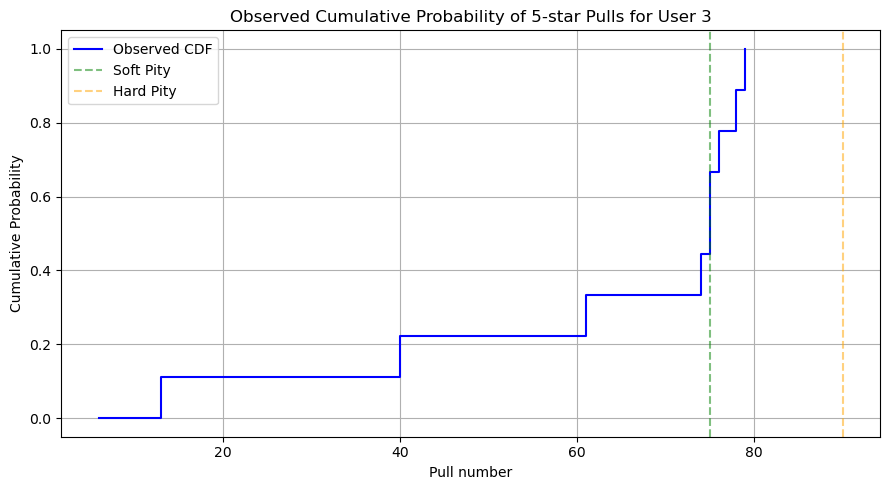

In [15]:
# observed cumulative probability of 5 star pulls for user3
five_star_df = user3_df[user3_df["rarity"] == 5]
pity_counts = five_star_df["pity_counter"].sort_values().reset_index(drop=True)
percentiles = np.linspace(0, 1, len(pity_counts), endpoint=True)

plt.figure(figsize=(9, 5))
plt.step(pity_counts, percentiles, where="post", label="Observed CDF", color="blue")

# add vertical lines for the soft pity and hard pity
plt.axvline(x=75, color='green', linestyle='--', label='Soft Pity', alpha=0.5)
plt.axvline(x=90, color='orange', linestyle='--', label='Hard Pity', alpha=0.5)

plt.xlabel("Pull number")
plt.ylabel("Cumulative Probability")
plt.title("Observed Cumulative Probability of 5-star Pulls for User 3")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. Bayesian Data Analysis - Simple Models

In [16]:
# create a new dataframe for user3
cleaned_df = user3_df.copy()
cleaned_df["is_win"] = (cleaned_df["rarity"] == 5).astype(int)
cleaned_df = cleaned_df[["pull_number", "rarity", "is_win", "pity_counter"]]
cleaned_df.head()

,pull_number,rarity,is_win,pity_counter
0,1,3,0,1
1,2,4,0,2
2,3,3,0,3
3,4,3,0,4
4,5,3,0,5


In [17]:
# for comparison
loo_scores = {}

#### 2.1 Beta-Bernoulli

In [18]:
with pm.Model() as m:
    # non-informative beta prior
    p = pm.Beta("p", alpha=1, beta=1)

    # Bernoulli likelihood for pulls
    y = pm.Bernoulli("y", p=p, observed=cleaned_df["is_win"])

    # sample from the posterior
    trace = pm.sample(10000, tune=1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})
    loo_scores["beta_bernoulli"] = az.loo(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


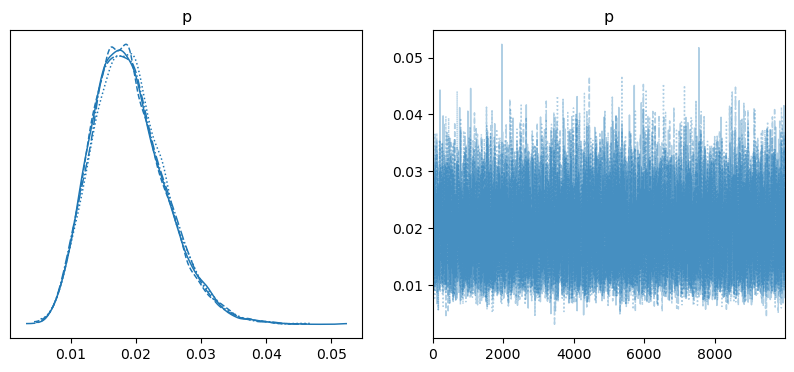

In [19]:
az.plot_trace(trace, var_names=["p"], figsize=(10, 4))
plt.show()

In [20]:
az.summary(trace, kind="stats", hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
p,0.019,0.006,0.009,0.03


This is above the advertised rate of 1.6%.

#### 2.2 Normal-Student's T

In [21]:
with pm.Model() as m_student:
    # non-informative priors
    mu = pm.Normal("mu", mu=50, sigma=50)
    sigma = pm.HalfNormal("sigma", sigma=20)

    # degrees of freedom
    nu = 1

    # deterministic variable for the probability of pulling a 5-star character
    p = pm.Deterministic("p", 1 - pm.math.exp(-1 / mu))

    # likelihood
    y = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=cleaned_df[cleaned_df["rarity"] == 5]["pity_counter"].values)

    # sample
    trace_student = pm.sample(10000, tune=1000, cores=1, return_inferencedata=True, idata_kwargs={"log_likelihood": True})
    loo_scores["student_t"] = az.loo(trace_student)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 4 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


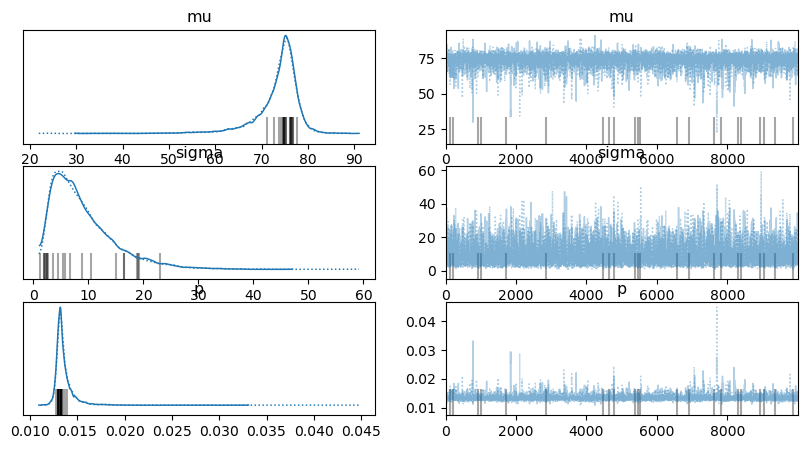

In [22]:
az.plot_trace(trace_student, var_names=["mu", "sigma", "p"], figsize=(10, 5))
plt.show()

In [23]:
az.summary(trace_student, kind='stats', hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
mu,73.514,4.835,63.450,81.066
sigma,8.980,5.781,1.245,20.621
p,0.014,0.001,0.012,0.016


This is not too bad, close to the expected 5-star win at ~73 pulls and the probability of winning is around 1.4%, which is a bit below the advertised rate.

In [24]:
loo_scores["beta_bernoulli"]

Computed from 40000 posterior samples and 580 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -51.52    12.67
p_loo        0.96        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      580  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [25]:
loo_scores["student_t"]

Computed from 20000 posterior samples and 10 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -48.40     5.33
p_loo        4.05        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       10  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

These are not a fair comparison since the number of observations fed to the model is different.

#### 2.3 Beta-Geometric

In [26]:
with pm.Model() as model_geo:
    p = pm.Beta("p", alpha=1, beta=1)

    # likelihood for the number of pulls until the first success
    pull_number = pm.Geometric("pull_number", p=p, observed=cleaned_df[cleaned_df["rarity"] == 5]["pity_counter"].values)

    trace_geo = pm.sample(10000, tune=1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

    loo_scores["geometric"] = az.loo(trace_geo)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


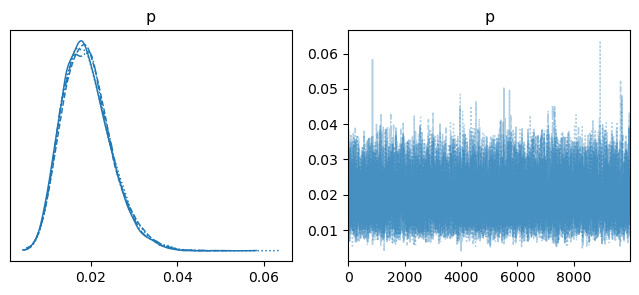

In [27]:
az.plot_trace(trace_geo, figsize=(8, 3), var_names=["p"])
plt.show()

In [28]:
az.summary(trace_geo, kind='stats', hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
p,0.019,0.006,0.009,0.03


The mean of the probability is too high, and the confidence intervals are extremely wide.

In [29]:
with model_geo:
    ppc = pm.sample_posterior_predictive(trace_geo, var_names=["pull_number"])

az.summary(ppc.posterior_predictive, kind='stats', hdi_prob=0.95)

Sampling: [pull_number]


Output()

,mean,sd,hdi_2.5%,hdi_97.5%
pull_number[0],57.823,62.498,1.0,180.0
pull_number[1],57.984,63.831,1.0,181.0
pull_number[2],57.893,63.113,1.0,181.0
pull_number[3],57.942,62.948,1.0,180.0
pull_number[4],57.526,62.962,1.0,178.0
pull_number[5],58.333,63.421,1.0,182.0
pull_number[6],57.729,62.785,1.0,179.0
pull_number[7],57.722,63.692,1.0,180.0
pull_number[8],57.851,63.536,1.0,179.0
pull_number[9],57.843,62.890,1.0,179.0


Not the quite expected value for pull numbers as well.

In [30]:
loo_scores_df = pd.DataFrame(loo_scores)
loo_scores_df.T[["elpd_loo", "se", "p_loo", "n_samples", "n_data_points", "warning"]].sort_values("elpd_loo", ascending=False)

,elpd_loo,se,p_loo,n_samples,n_data_points,warning
student_t,-48.397065,5.331278,4.048588,20000,10,False
geometric,-51.125914,1.590203,0.288993,40000,10,False
beta_bernoulli,-51.522048,12.672019,0.958824,40000,580,False


### 3. Bayesian Data Analysis - Complex Models

#### 3.1 pymetalog Metalog prior distribution
* [The code base is forked](https://github.com/jinjin-tonic/pymetalog) from the original library [pymetalog](https://github.com/tjefferies/pymetalog) and locally imported.

In [31]:
# fitting the data
pull_data = np.sort(np.array([13, 40, 75,  6, 76, 78, 61, 74, 75, 79]))
dist = mt.metalog(x = pull_data, term_limit=4, bounds=[0, 90], boundedness="b")

/Users/haejin.cho/Documents/OMSCS/ISYE6420/pymetalog/pymetalog/support.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x.loc[i, "probs"] = 0.5 / l


In [32]:
dist.output_dict['dataValues']

,x,probs,z
0,6,0.05,-2.639057
1,13,0.15,-1.778856
2,40,0.25,-0.223144
3,61,0.35,0.743578
4,74,0.45,1.531476
5,75,0.55,1.609438
6,75,0.65,1.609438
7,76,0.75,1.691676
8,78,0.85,1.871802
9,79,0.95,1.971553


In [33]:
dist.output_dict['A']

,a2,a3,a4
0,0.638790,1.271196,1.271196
1,0.847675,0.847675,0.481315
2,0.000000,-1.369050,-1.369050
3,0.000000,0.000000,2.111086


These are the coefficients of the metalog distribution, each of which correcponds to 2 terms, 3 terms, and 4 terms parameterizations.

In [34]:
mt.summary(dist)

 -----------------------------------------------
 Summary of Metalog Distribution Object
 -----------------------------------------------
 
Parameters
 Term Limit:  4 
 Term Lower Bound:  2 
 Boundedness:  b 
 Bounds (only used based on boundedness):  [0, 90] 
 Step Length for Distribution Summary:  0.01 
 Method Use for Fitting:  any 
 

 Validation and Fit Method Number of Data Points Used:  10 

 term valid method
    2   yes    OLS
    3   yes    OLS
    4   yes    OLS


{'pdf': <Figure size 1300x400 with 3 Axes>,
 'cdf': <Figure size 1300x400 with 3 Axes>}

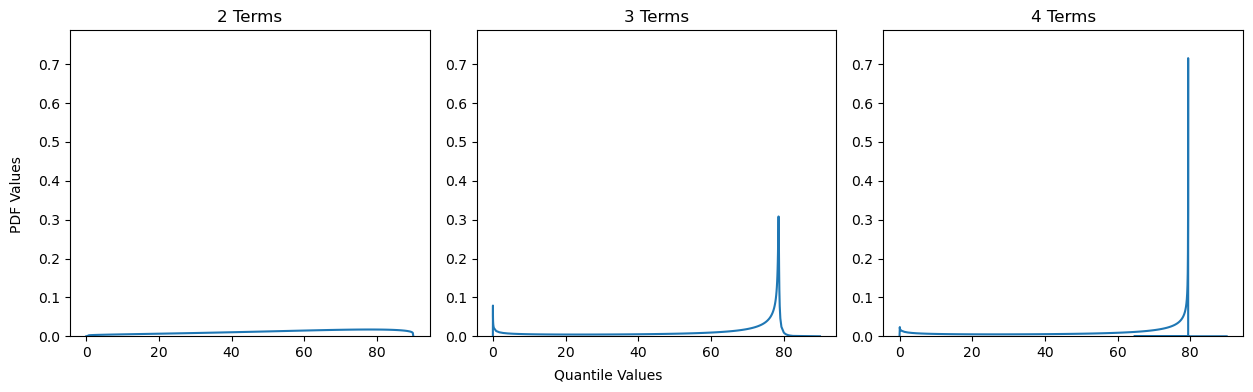

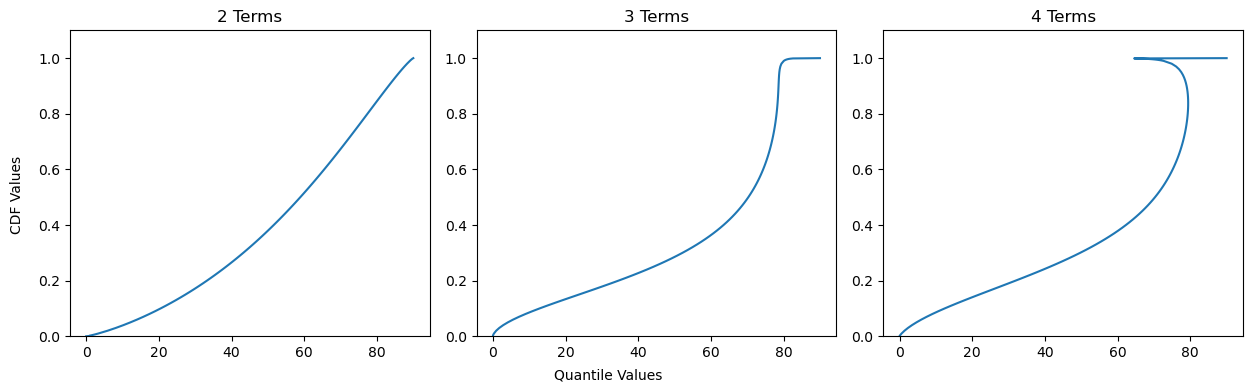

In [35]:
mt.plot(dist, figsize=(13,4))

Since 2-term is too simple, and 4-term is too much emphasis on the pulls around 80, we can try with 3-term parameterizations.

In [36]:
# PDF example
mt.support.pdfMetalog(
    a=dist.output_dict["A"]["a3"].values,
    y=0.009,
    t=3,
    bounds=[0,90],
    boundedness="b"
)

0.02248339673580346

In [37]:
# PPF Example
mt.support.quantileMetalog(
    a=dist.output_dict["A"]["a3"].values,
    y=0.009,
    t=3,
    bounds=[0,90],
    boundedness="b"
)

0.25221014972676686

The two code blocks above show how to use the pdf function and the quantile function with the fitted coefficients.

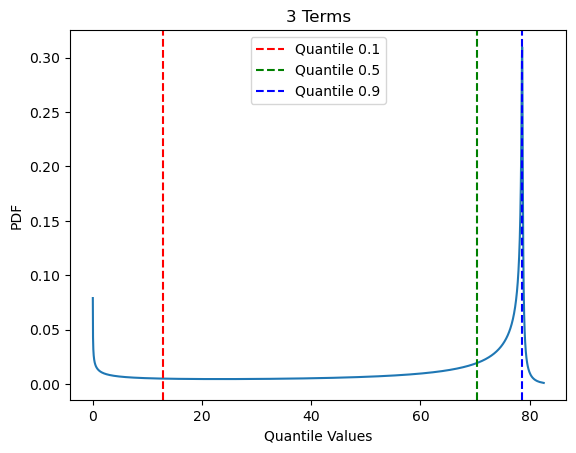

In [38]:
# plot the metalog pdf with 3-term
y_vals = np.linspace(0.001, 0.999, 1000)

pdf_vals = [mt.support.pdfMetalog(
    a=dist.output_dict["A"]["a3"].values,
    y=y,
    t=3,
    bounds=[0, 90],
    boundedness="b"
) for y in y_vals]

quantile_vals = [mt.support.quantileMetalog(
    a=dist.output_dict["A"]["a3"].values,
    y=y,
    t=3,
    bounds=[0, 90],
    boundedness="b"
) for y in y_vals]

quantiles_to_mark = [0.1, 0.5, 0.9]
quantile_values = [
    mt.support.quantileMetalog(
        a=dist.output_dict["A"]["a3"].values,
        y=q,
        t=3,
        bounds=[0, 90],
        boundedness="b"
    ) for q in quantiles_to_mark
]

# Plotting
plt.plot(quantile_vals, pdf_vals)
plt.axvline(x=quantile_values[0], color='red', linestyle='--', label=f"Quantile {quantiles_to_mark[0]}")
plt.axvline(x=quantile_values[1], color='green', linestyle='--', label=f"Quantile {quantiles_to_mark[1]}")
plt.axvline(x=quantile_values[2], color='blue', linestyle='--', label=f"Quantile {quantiles_to_mark[2]}")
plt.legend()

plt.title("3 Terms")
plt.xlabel("Quantile Values")
plt.ylabel("PDF")
plt.show()

#### 3.2 Metalog-Bernoulli

Define some support functions.

In [39]:
def logpMetalog_pt(y, a, t, bounds, boundedness="b"):
    pdf_val = mt.support.pdfMetalog_pt(a, y, t, bounds, boundedness)
    return pt.log(pdf_val)

In [40]:
with pm.Model() as model_metalog_bernoulli:
    lower_bound = 0
    upper_bound = 90
    
    a_vals = dist.output_dict["A"]["a3"].values
    t = 3
    bounds = [lower_bound, upper_bound]
    
    def metalog_logp(theta):
        return logpMetalog_pt(theta, a_vals, t, bounds, boundedness="b")

    θ = pm.DensityDist("theta", logp=metalog_logp)
    p = pm.Deterministic("p", pm.math.exp(θ))

    # Bernoulli likelihood
    y = pm.Bernoulli("y", p=p, observed=cleaned_df["is_win"].values)

    # Posterior sampling
    trace_metalog_bernoulli = pm.sample(10000, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


In [41]:
az.summary(trace_metalog_bernoulli, kind='stats', hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
theta,-4.113,0.324,-4.743,-3.490
p,0.017,0.005,0.007,0.028


<Axes: title={'center': 'p'}>

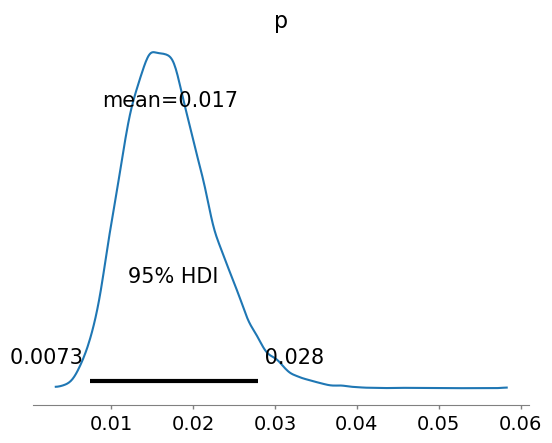

In [42]:
az.plot_posterior(trace_metalog_bernoulli, var_names=["p"], hdi_prob=0.95)

The probability mean is quite close to 1.6%, but the credible interval seems a bit wide.

#### 3.3 Metalog-Geometric

In [43]:
user3_wins = np.sort(user3_df[user3_df.rarity == 5].pity_counter.values)
user3_wins

array([ 6, 13, 40, 61, 74, 75, 75, 76, 78, 79])

In [44]:
with pm.Model() as model_metalog_geometric:
    lower_bound = 0
    upper_bound = 90
    
    a_vals = dist.output_dict["A"]["a3"].values
    t = 3
    bounds = [lower_bound, upper_bound]
    
    def metalog_logp(theta):
        return logpMetalog_pt(theta, a_vals, t, bounds, boundedness="b")

    θ = pm.DensityDist("theta", logp=metalog_logp)
    p = pm.Deterministic("p", pm.math.sigmoid(θ))
    mu = pm.Deterministic("mu", 1 / p)

    # likelihood
    y = pm.Geometric("y", p=p, observed=user3_wins)

    # Posterior sampling
    trace_metalog_geometric = pm.sample(1000, tune=1000, return_inferencedata=True,target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [45]:
az.summary(trace_metalog_geometric, kind='stats', hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
theta,-4.067,0.322,-4.700,-3.429
p,0.018,0.005,0.008,0.029
mu,62.617,21.433,29.525,105.186


The mean value is far off from the data's mean, and p's credible inverval is wide as well.

#### 3.4 Metalog-Student's T

In [46]:
with pm.Model() as m_metalog_student:
    nu = 1
    lower_bound = 0
    upper_bound = 90
    
    a_vals = dist.output_dict["A"]["a3"].values
    t = 3
    bounds = [lower_bound, upper_bound]
    
    def metalog_logp(theta):
        return logpMetalog_pt(theta, a_vals, t, bounds, boundedness="b")

    # sigma = pm.HalfNormal("sigma", sigma=20)
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    θ = pm.DensityDist("theta", logp=metalog_logp)
    p = pm.Deterministic("p", pm.math.sigmoid(θ))
    mu = pm.Deterministic("mu", 1 / -np.log(1 - p))

    # likelihood
    y = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=pull_data)

    # sample
    trace_metalog_student = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [47]:
az.summary(trace_metalog_student, kind='stats', hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
theta,-4.304,0.049,-4.380,-4.205
tau,0.080,0.110,0.000,0.279
sigma,6.460,5.144,1.034,15.980
p,0.013,0.001,0.012,0.015
mu,74.581,3.362,67.528,80.301


Mu is close to the expected mean, but p is quite lower than the advertised rate.

#### 3.5 Hierarchy - Metalog - Student's T

Let's try utilize all users data.

In [48]:
user1_df_11 = user1_df_11.reset_index().drop(columns=["index"])
user2_df_11 = user2_df_11.reset_index().drop(columns=["index"])

# add pity count
curr_pity = 0
for i in range(len(user1_df_11)):
    curr_pity += 1
    user1_df_11.loc[i, "pity_counter"] = curr_pity

    if user1_df_11.loc[i, "rarity"] == 5:
        curr_pity = 0

curr_pity = 0
for i in range(len(user2_df_11)):
    curr_pity += 1
    user2_df_11.loc[i, "pity_counter"] = curr_pity

    if user2_df_11.loc[i, "rarity"] == 5:
        curr_pity = 0

In [49]:
user1_df_11["user"] = "user1"
user2_df_11["user"] = "user2"
user3_df["user"] = "user3"

In [50]:
user1_df_clean = user1_df_11[["pity_counter", "user", "rarity"]]
user1_df_clean = user1_df_clean[user1_df_clean["rarity"] == 5]
user2_df_clean = user2_df_11[["pity_counter", "user", "rarity"]]
user2_df_clean = user2_df_clean[user2_df_clean["rarity"] == 5]
user3_df_clean = user3_df[["pity_counter", "user", "rarity"]]
user3_df_clean = user3_df_clean[user3_df_clean["rarity"] == 5]

In [51]:
all_data = pd.concat([user1_df_clean, user2_df_clean, user3_df_clean], ignore_index=True)
user_idx, user_labels = pd.factorize(all_data["user"])
pull_data = all_data["pity_counter"].values

In [52]:
with pm.Model() as m_hier_student:
    nu = 1
    lower_bound = 0
    upper_bound = 90

    # Metalog prior
    a_vals = dist.output_dict["A"]["a3"].values
    t = 3
    bounds = [lower_bound, upper_bound]

    def metalog_logp(theta):
        return logpMetalog_pt(theta, a_vals, t, bounds, boundedness="b")

    # Hyperpriors
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    # User-specific θs from Metalog prior
    θ_user = pm.DensityDist("theta_user", logp=metalog_logp, shape=len(user_labels))

    # Map θ_user to each user's pull
    θ_obs = θ_user[user_idx]
    p = pm.Deterministic("p", pm.math.sigmoid(θ_obs))
    mu = pm.Deterministic("mu", 1 / -pm.math.log(1 - p))

    # Likelihood
    y = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=pull_data)

    trace_hier_student = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, theta_user]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [53]:
mu_samples = trace_hier_student.posterior["mu"]
user1_mu = mu_samples[..., all_data["user"] == "user1"]
user2_mu = mu_samples[..., all_data["user"] == "user2"]
user3_mu = mu_samples[..., all_data["user"] == "user3"]

p_samples = trace_hier_student.posterior["p"]
user1_p = p_samples[..., all_data["user"] == "user1"]
user2_p = p_samples[..., all_data["user"] == "user2"]
user3_p = p_samples[..., all_data["user"] == "user3"]

In [54]:
# this code is adapted from the lecture note
def calc_hdi(samples: np.ndarray, alpha: float = 0.05) -> tuple:
    """
    Calculate minimum-width credible interval (HPD credible set)

    samples: samples from posterior
    alpha: credibility of the interval == 1 - alpha

    returns tuple of the lower and upper bounds of the interval
    """
    n = len(samples)
    x = np.sort(samples)

    lower_idx = int(np.floor(alpha * n))
    x_left = x[:lower_idx]
    x_right = x[n - lower_idx :]

    idx = np.argmin(x_right - x_left)

    upper_bound = x_right[idx]
    lower_bound = x_left[idx]

    return lower_bound, upper_bound

In [55]:
print(f"Mean pull number of user1: {user1_mu.values.flatten().mean():.4}")
lwr1, upr1 = calc_hdi(user1_mu.values.flatten())
print(f"95% HDI credible interval of user1: ({lwr1:.4}, {upr1:.4})")

print(f"Mean pull number of user2: {user2_mu.values.flatten().mean():.4}")
lwr2, upr2 = calc_hdi(user2_mu.values.flatten())
print(f"95% HDI credible interval of user2: ({lwr2:.4}, {upr2:.4})")

print(f"Mean pull number of user3: {user3_mu.values.flatten().mean():.4}")
lwr3, upr3 = calc_hdi(user3_mu.values.flatten())
print(f"95% HDI credible interval of user3: ({lwr3:.4}, {upr3:.4})")

Mean pull number of user1: 69.68
95% HDI credible interval of user1: (25.53, 94.51)
Mean pull number of user2: 74.6
95% HDI credible interval of user2: (62.14, 84.78)
Mean pull number of user3: 73.77
95% HDI credible interval of user3: (64.51, 81.29)


In [56]:
print(f"Mean p of user1: {user1_p.values.flatten().mean():.4}")
lwr1, upr1 = calc_hdi(user1_p.values.flatten())
print(f"95% HDI credible interval of user1: ({lwr1:.4}, {upr1:.4})")

print(f"Mean p number of user2: {user2_p.values.flatten().mean():.4}")
lwr2, upr2 = calc_hdi(user2_p.values.flatten())
print(f"95% HDI credible interval of user2: ({lwr2:.4}, {upr2:.4})")

print(f"Mean p number of user3: {user3_p.values.flatten().mean():.4}")
lwr3, upr3 = calc_hdi(user3_p.values.flatten())
print(f"95% HDI credible interval of user3: ({lwr3:.4}, {upr3:.4})")

Mean p of user1: 0.01894
95% HDI credible interval of user1: (0.009601, 0.03497)
Mean p number of user2: 0.01345
95% HDI credible interval of user2: (0.01169, 0.0159)
Mean p number of user3: 0.01352
95% HDI credible interval of user3: (0.01223, 0.01538)


#### 3.6 Comparison with non-informative prior

In [57]:
# non-informative prior

with pm.Model() as m_hier_student:
    nu = 1  # degrees of freedom for Student's T

    # Non-informative prior over user-specific success probabilities
    p = pm.Beta("p", alpha=1, beta=1, shape=len(user_labels))

    # Convert p to expected value of geometric distribution (mean pulls to 5-star)
    mu = pm.Deterministic("mu", 1 / -pm.math.log(1 - p))

    # Map mu to observed users
    mu_obs = mu[user_idx]

    # Hierarchical variance via Gamma hyperprior
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    # Student's T likelihood over observed pulls
    y = pm.StudentT("y", mu=mu_obs, sigma=sigma, nu=nu, observed=pull_data)

    trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, tau]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [58]:
az.summary(trace, var_names=["p", "mu"], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.102,0.210,0.009,0.671,0.014,0.010,246.0,374.0,1.02
p[1],0.014,0.003,0.011,0.018,0.000,0.000,465.0,255.0,1.01
p[2],0.014,0.002,0.012,0.016,0.000,0.000,408.0,392.0,1.01
mu[0],51.296,29.665,0.394,84.049,2.269,1.607,246.0,459.0,1.02
mu[1],73.194,8.433,54.244,85.256,0.512,0.363,465.0,255.0,1.01
mu[2],72.768,5.541,61.329,80.177,0.323,0.228,408.0,389.0,1.01


Using the non-informative prior returns a very different prediction for user1, compared to the metalog prior. User1's predicted $p$ is also very high.

#### 3.7 Comparison with Different Likelihood Models

In [59]:
user1_pulls = user1_df[["rarity"]]
user1_pulls["user"] = "user1"
user2_pulls = user2_df[["rarity"]]
user2_pulls["user"] = "user2"
user3_pulls = user3_df[["rarity"]]
user3_pulls["user"] = "user3"
all_pulls = pd.concat([user1_pulls, user2_pulls, user3_pulls], ignore_index=True)

/var/folders/qf/j7wht0hj5z199zk3gbhnlfj00000gn/T/ipykernel_18939/2127791358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user1_pulls["user"] = "user1"
/var/folders/qf/j7wht0hj5z199zk3gbhnlfj00000gn/T/ipykernel_18939/2127791358.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user2_pulls["user"] = "user2"
/var/folders/qf/j7wht0hj5z199zk3gbhnlfj00000gn/T/ipykernel_18939/2127791358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [60]:
all_pulls["is_win"] = (all_pulls["rarity"] == 5).astype(int)

In [61]:
all_pulls.head()

,rarity,user,is_win
0,3,user1,0
1,3,user1,0
2,3,user1,0
3,3,user1,0
4,3,user1,0


In [62]:
user_idx, user_labels = pd.factorize(all_pulls["user"])
win_data = all_pulls["is_win"].values

In [63]:
with pm.Model() as m_hier_bernoulli:
    # nu = 1
    lower_bound = 0
    upper_bound = 90

    # Metalog prior
    a_vals = dist.output_dict["A"]["a3"].values
    t = 3
    bounds = [lower_bound, upper_bound]

    def metalog_logp(theta):
        return logpMetalog_pt(theta, a_vals, t, bounds, boundedness="b")

    θ_user = pm.DensityDist("theta_user", logp=metalog_logp, shape=len(user_labels))
    θ_obs = θ_user[user_idx]
    p = pm.Deterministic("p", pm.math.sigmoid(θ_obs))
    mu = pm.Deterministic("mu", 1 / -pm.math.log(1 - p))

    # Likelihood
    y = pm.Bernoulli("y", p=p, observed=win_data)

    trace_hier_bernoulli = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_user]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [64]:
az.summary(trace_hier_bernoulli, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_user[0],-3.858,0.416,-4.677,-3.083,0.006,0.005,4424.0,2406.0,1.0
theta_user[1],-4.105,0.353,-4.811,-3.441,0.005,0.004,4458.0,2966.0,1.0
theta_user[2],-4.087,0.326,-4.708,-3.465,0.005,0.004,4614.0,3062.0,1.0
p[0],0.022,0.009,0.007,0.040,0.000,0.000,4424.0,2406.0,1.0
p[1],0.022,0.009,0.007,0.040,0.000,0.000,4424.0,2406.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[1368],63.476,22.686,29.627,108.446,0.378,0.320,4614.0,3062.0,1.0
mu[1369],63.476,22.686,29.627,108.446,0.378,0.320,4614.0,3062.0,1.0
mu[1370],63.476,22.686,29.627,108.446,0.378,0.320,4614.0,3062.0,1.0
mu[1371],63.476,22.686,29.627,108.446,0.378,0.320,4614.0,3062.0,1.0


In [65]:
mu_samples = trace_hier_bernoulli.posterior["mu"]
user1_mu = mu_samples[..., all_pulls["user"] == "user1"]
user2_mu = mu_samples[..., all_pulls["user"] == "user2"]
user3_mu = mu_samples[..., all_pulls["user"] == "user3"]

p_samples = trace_hier_bernoulli.posterior["p"]
user1_p = p_samples[..., all_pulls["user"] == "user1"]
user2_p = p_samples[..., all_pulls["user"] == "user2"]
user3_p = p_samples[..., all_pulls["user"] == "user3"]


print(f"Mean pull number of user1: {user1_mu.values.flatten().mean():.4}")
lwr1, upr1 = calc_hdi(user1_mu.values.flatten())
print(f"95% HDI credible interval of user1: ({lwr1:.4}, {upr1:.4})")

print(f"Mean pull number of user2: {user2_mu.values.flatten().mean():.4}")
lwr2, upr2 = calc_hdi(user2_mu.values.flatten())
print(f"95% HDI credible interval of user2: ({lwr2:.4}, {upr2:.4})")

print(f"Mean pull number of user3: {user3_mu.values.flatten().mean():.4}")
lwr3, upr3 = calc_hdi(user3_mu.values.flatten())
print(f"95% HDI credible interval of user3: ({lwr3:.4}, {upr3:.4})")

print()

print(f"Mean p of user1: {user1_p.values.flatten().mean():.4}")
lwr1, upr1 = calc_hdi(user1_p.values.flatten())
print(f"95% HDI credible interval of user1: ({lwr1:.4}, {upr1:.4})")

print(f"Mean p number of user2: {user2_p.values.flatten().mean():.4}")
lwr2, upr2 = calc_hdi(user2_p.values.flatten())
print(f"95% HDI credible interval of user2: ({lwr2:.4}, {upr2:.4})")

print(f"Mean p number of user3: {user3_p.values.flatten().mean():.4}")
lwr3, upr3 = calc_hdi(user3_p.values.flatten())
print(f"95% HDI credible interval of user3: ({lwr3:.4}, {upr3:.4})")

Mean pull number of user1: 52.43
95% HDI credible interval of user1: (18.54, 100.4)
Mean pull number of user2: 65.26
95% HDI credible interval of user2: (29.87, 118.1)
Mean pull number of user3: 63.48
95% HDI credible interval of user3: (29.63, 108.4)

Mean p of user1: 0.02232
95% HDI credible interval of user1: (0.006932, 0.03954)
Mean p number of user2: 0.01716
95% HDI credible interval of user2: (0.006865, 0.02846)
Mean p number of user3: 0.01733
95% HDI credible interval of user3: (0.008016, 0.02838)


#### 3.8 Final Model

In [66]:
with pm.Model() as m_student2:
    nu = 1
    lower_bound = 0
    upper_bound = 90
    
    a_vals = dist.output_dict["A"]["a3"].values
    t = 3
    bounds = [lower_bound, upper_bound]
    
    def metalog_logp(theta):
        return logpMetalog_pt(theta, a_vals, t, bounds, boundedness="b")

    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    θ = pm.DensityDist("theta", logp=metalog_logp)
    p = pm.Deterministic("p", pm.math.sigmoid(θ))
    mu = pm.Deterministic("mu", 1 / -np.log(1 - p))

    # likelihood
    y = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=all_data.pity_counter.values)

    # sample
    trace_student2 = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [67]:
az.summary(trace_student2, kind='stats', hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
theta,-4.319,0.027,-4.367,-4.273
tau,0.054,0.051,0.001,0.142
sigma,5.612,2.698,1.751,10.917
p,0.013,0.000,0.013,0.014
mu,75.622,1.960,72.267,79.290


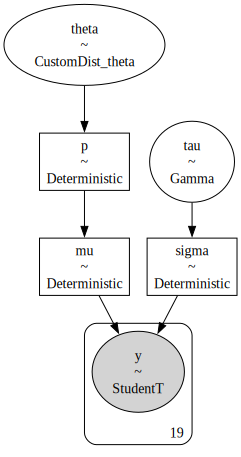

In [81]:
pm.model_to_graphviz(m_student2)

In [78]:
user_idx, user_labels = pd.factorize(all_data["user"])
pull_data = all_data["pity_counter"].values

with pm.Model() as m_hier_student2:
    nu = 1
    lower_bound = 0
    upper_bound = 90

    # Metalog prior
    a_vals = dist.output_dict["A"]["a3"].values
    t = 3
    bounds = [lower_bound, upper_bound]

    def metalog_logp(theta):
        return logpMetalog_pt(theta, a_vals, t, bounds, boundedness="b")

    # Hyperpriors
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    # User-specific θs from Metalog prior
    θ_user = pm.DensityDist("theta_user", logp=metalog_logp, shape=len(user_labels))

    # Map θ_user to each user's pull
    θ_obs = θ_user[user_idx]
    p = pm.Deterministic("p", pm.math.sigmoid(θ_obs))
    mu = pm.Deterministic("mu", 1 / -pm.math.log(1 - p))

    # Likelihood
    y = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=pull_data)

    trace_hier_studen2t = pm.sample(2000, tune=1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, theta_user]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [79]:
mu_samples = trace_hier_studen2t.posterior["mu"]
p_samples = trace_hier_studen2t.posterior["p"]

user_mask = {
    "user1": all_data["user"] == "user1",
    "user2": all_data["user"] == "user2",
    "user3": all_data["user"] == "user3",
}

results = []

for user, mask in user_mask.items():
    user_mu = mu_samples[..., mask].values.flatten()
    user_p = p_samples[..., mask].values.flatten()

    mu_mean = user_mu.mean()
    mu_lwr, mu_upr = calc_hdi(user_mu)

    p_mean = user_p.mean()
    p_lwr, p_upr = calc_hdi(user_p)

    results.append({
        "user": user,
        "mu_mean": mu_mean,
        "mu_hdi_3%": mu_lwr,
        "mu_hdi_97%": mu_upr,
        "p_mean": p_mean,
        "p_hdi_2.5%": p_lwr,
        "p_hdi_97.5%": p_upr,
    })

df_summary = pd.DataFrame(results)
df_summary.round(4)

,user,mu_mean,mu_hdi_3%,mu_hdi_97%,p_mean,p_hdi_2.5%,p_hdi_97.5%
0,user1,69.3045,26.4754,92.7880,0.0189,0.0095,0.0340
1,user2,74.9185,64.1398,84.3690,0.0139,0.0115,0.0151
2,user3,74.0030,65.7343,80.7669,0.0135,0.0123,0.0150


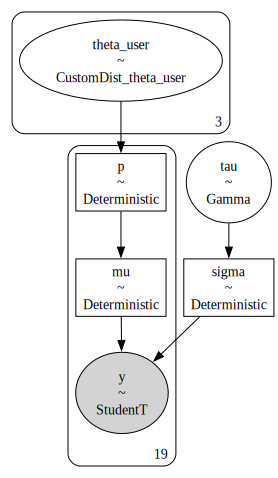

In [80]:
pm.model_to_graphviz(m_hier_student2)

The good:
* Expected pulls for 5-star seems to be correct. Tho, the credible intervals of the user1 is quite wide, but it is due to the limitation of only having 3 data points.

Limitation: 
* Samples from out of range (max sample = 120, which is not possible)
* Couldn't properly estimated the advertised rate of 1.6% with this model.

### 4. Appendix - SPT Implementation Trial

This section is based on the formulation presented in the original paper, specifically the SPT Log Metalog distribution for bounded data. Since our observations are constrained between 1 and 90, we adopt the bounded form as described in the official documentation: [SPT Bounded Metalog Equations](http://www.metalogdistributions.com/equations/sptboundedmetalog.html).

To do the SPT parameterization, we need to know $q_\alpha$, $q_{0.5}$, and $q_{1-\alpha}$. Let's say $\alpha = 0.1$.

In [70]:
win_pity_counts = cleaned_df[cleaned_df.is_win == 1].pity_counter.values
win_pity_counts = np.sort(win_pity_counts)
p10_index = len(win_pity_counts) * 0.1
p50_index = len(win_pity_counts) * 0.5
p90_index = len(win_pity_counts) * 0.9
print("p10, p50, p90: ", win_pity_counts[int(p10_index)], win_pity_counts[int(p50_index)], win_pity_counts[int(p90_index)])

p10, p50, p90:  13 75 79


In [71]:
def metalog_qdf(y, a: np.ndarray, bl: float = 0.0, bu: float = 90.0):
    """
    Calculate the quantile function for SPT parameterization of the metalog distribution.
    """
    if y == 0:
        return bl
    if y == 1:
        return bu

    a1, a2, a3 = a
    y_log_term = np.log(y / (1 - y))
    y_term = y - 0.5
    M_y = a1 + a2 * y_log_term + a3 * y_term * y_log_term

    return (bl + bu * np.exp(M_y)) / (1 + np.exp(M_y))

In [72]:
def metalog_pdf(y, a: np.ndarray, bl: float = 0.0, bu: float = 90.0):
    """
    Calculate the quantile function for SPT parameterization of the metalog distribution.
    """
    if y == 0 or y == 1:
        return 0

    _, a2, a3 = a

    y_term = y * (1 - y)
    y_log_term = np.log(y / (1 - y))

    m_y = 1 / (a2 / y_term + a3 * (((y - 0.5) / y_term)) + y_log_term)
    M_y = metalog_qdf(y, a, bl, bu)

    return m_y * ((1 + np.exp(M_y)) ** 2 / ((bu - bl) * np.exp(M_y)))

In [73]:
def check_feasibility(alpha, gamma_10, gamma_50, gamma_90, bl: float = 0.0, bu: float = 90.0):
    k_a = 0.5 * (1 - 1.66711 * (0.5 - alpha))

    lower_bound = (bl + bu * (gamma_10 ** (1 - k_a)) * gamma_90 ** (k_a)) * np.reciprocal(1 + (gamma_10 ** (1 - k_a)) * (gamma_90 ** k_a))
    upper_bound = (bl + bu * (gamma_10 ** k_a) * gamma_90 ** (1 - k_a)) * np.reciprocal(1 + (gamma_10 ** k_a) * (gamma_90 ** (1 - k_a)))

    print("lower bound: ", lower_bound)
    print("upper bound: ", upper_bound)
    print("gamma_50: ", gamma_50)

    return lower_bound <= gamma_50 <= upper_bound, lower_bound, upper_bound

In [74]:
def calculate_constants(q10, q50, q90, bl: float = 0.0, bu: float = 90.0):
    """
    Calculate the constants for the metalog distribution.
    """
    a = np.zeros(3)
    alpha = 0.1
    
    gamma_10 = (q10 - bl) / (bu - q10)
    gamma_50 = (q50 - bl) / (bu - q50)
    gamma_90 = (q90 - bl) / (bu - q90)

    # Check feasibility
    is_feasible, lwr, upr = check_feasibility(alpha, gamma_10, gamma_50, gamma_90, bl, bu)

    if not is_feasible:
        raise ValueError(f"The parameters are not feasible for the metalog distribution: {lwr} <= {gamma_50} <= {upr}")

    a[0] = np.log(gamma_50)
    a[1] = 0.5 * np.reciprocal(np.log ((1 - alpha) / alpha)) * np.log(gamma_90 / gamma_10)
    a[2] = np.reciprocal((1 - 2*alpha) * np.log((1 - alpha) / alpha)) * np.log((gamma_90*gamma_10) / gamma_50 ** 2)

    return a

In [75]:
a = calculate_constants(13, 75, 79, bl=1, bu=90)
a

lower bound:  21.240147737611274
upper bound:  71.27958428030678
gamma_50:  4.933333333333334


ValueError: The parameters are not feasible for the metalog distribution: 21.240147737611274 <= 4.933333333333334 <= 71.27958428030678

Unfortuantely, the data we have is not feasible for SPT parameterization.

In [ ]:
# Let's say we had the data like this
a = calculate_constants(1, 71, 80, bl=0, bu=90)
a

lower bound:  2.9219911453857095
upper bound:  65.53506115786132
gamma_50:  3.736842105263158


array([ 1.3182409 ,  1.49463054, -2.87048299])

lower bound:  2.9219911453857095
upper bound:  65.53506115786132
gamma_50:  3.736842105263158


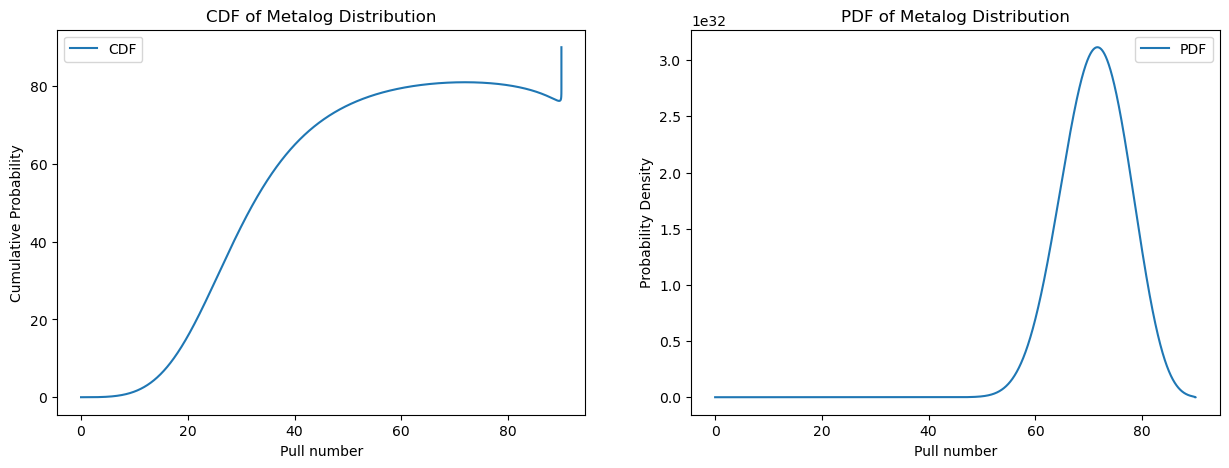

In [ ]:
# convert y to pity counter
x = np.linspace(0, 90, 100000)
y = np.linspace(0, 1, 100000)
a = calculate_constants(1, 71, 80, bl=0, bu=90)

xfunc = lambda y : metalog_qdf(y, a)
yfunc = lambda y : metalog_pdf(y, a)

xs = np.array(list(map(xfunc, y)))
ys = np.array(list(map(yfunc, y)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(x, xs, label="CDF")
ax1.set_xlabel("Pull number")
ax1.set_ylabel("Cumulative Probability")
ax1.set_title("CDF of Metalog Distribution")
ax1.legend()

ax2.plot(x, ys, label="PDF")
ax2.set_xlabel("Pull number")
ax2.set_ylabel("Probability Density")
ax2.set_title("PDF of Metalog Distribution")
ax2.legend()

plt.show()

Not really sure if the implementation is wrong or this data is really infeasible.